## Speech and Speaker Recognition - DT2119 VT19-1 

### HMM - Lab 2

In [2]:
from __future__ import print_function

import numpy as np
import math

from lab2_tools import *

import prondict as prondict

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
%matplotlib inline
from tqdm import tqdm

### 3 Data and model set

In [4]:
example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()
for x in example.keys(): 
    print(x, end = '\t')
    if x in ['digit', 'gender', 'filename', 'samplingrate', 'speaker', 'repetition']:
        print(example.get(x))
    else:
        print(example.get(x).shape)

filename	/home/giampi/corpora/tidigits/disc_4.2.1/tidigits/test/woman/ew/oa.wav
samplingrate	20000
gender	woman
speaker	ew
digit	o
repetition	a
samples	(14592,)
lmfcc	(71, 13)
obsloglik	(71, 9)
logalpha	(71, 9)
loglik	()
vloglik	()
vpath	(71,)
logbeta	(71, 9)
loggamma	(71, 9)


In [6]:
data = np.load('lab2_data.npz', allow_pickle=True)['data']
for x in data[0]: 
    print(x, end = '\t')
    
    if x in ['digit', 'gender', 'filename', 'samplingrate', 'speaker', 'repetition']:
        print(example.get(x))
    else:
        print(example.get(x).shape)

filename	/home/giampi/corpora/tidigits/disc_4.2.1/tidigits/test/woman/ew/oa.wav
samplingrate	20000
gender	woman
speaker	ew
digit	o
repetition	a
samples	(14592,)
lmfcc	(71, 13)


### 3.1 The phonetic models

In [8]:
phoneHMMs_one = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()
for x in phoneHMMs_one.keys(): 
    print(x, end = '\t')
print('\n', len(phoneHMMs_one))

f	k	n	r	s	t	v	w	z	ah	ao	ay	eh	ey	ih	iy	ow	sp	th	uw	sil	
 21


In [11]:
models = np.load('lab2_models_all.npz', allow_pickle=True)
for k in models.files:
    print(k)

phoneHMMs


In [12]:
phoneHMMs_all = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
for x in phoneHMMs_all.keys(): print(x, end = '\t')

f	k	n	r	s	t	v	w	z	ah	ao	ay	eh	ey	ih	iy	ow	sp	th	uw	sil	

In [13]:
print(phoneHMMs_one['ah'].keys())

dict_keys(['name', 'startprob', 'transmat', 'means', 'covars'])


### 3.2 Pronunciation dictionary and utterance models

In [14]:
prondict = {} 
prondict['o'] = ['ow']
prondict['z'] = ['z', 'iy', 'r', 'ow']
prondict['1'] = ['w', 'ah', 'n']
prondict['2'] = ['t', 'uw']
prondict['3'] = ['th', 'r', 'iy']
prondict['4'] = ['f', 'ao', 'r']
prondict['5'] = ['f', 'ay', 'v']
prondict['6'] = ['s', 'ih', 'k', 's']
prondict['7'] = ['s', 'eh', 'v', 'ah', 'n']
prondict['8'] = ['ey', 't']
prondict['9'] = ['n', 'ay', 'n']

### 4 Concatenating HMMs

In [15]:
# this is already implemented, but based on concat2HMMs() above
def concatHMMs(hmmmodels, namelist):
    """ Concatenates HMM models in a left to right manner

    Args:
       hmmmodels: dictionary of models indexed by model name. 
       hmmmodels[name] is a dictionaries with the following keys:
           name: phonetic or word symbol corresponding to the model
           startprob: M+1 array with priori probability of state
           transmat: (M+1)x(M+1) transition matrix
           means: MxD array of mean vectors
           covars: MxD array of variances
       namelist: list of model names that we want to concatenate

    D is the dimension of the feature vectors
    M is the number of emitting states in each HMM model (could be
      different in each model)

    Output
       combinedhmm: dictionary with the same keys as the input but
                    combined models:
         startprob: K+1 array with priori probability of state
          transmat: (K+1)x(K+1) transition matrix
             means: KxD array of mean vectors
            covars: KxD array of variances

    K is the sum of the number of emitting states from the input models

    Example:
       wordHMMs['o'] = concatHMMs(phoneHMMs, ['sil', 'ow', 'sil'])
    """
    concat = hmmmodels[namelist[0]]
    for idx in range(1,len(namelist)):
        concat = concatTwoHMMs(concat, hmmmodels[namelist[idx]])
    return concat

In [16]:
def concatTwoHMMs(hmm1, hmm2):
    """ Concatenates 2 HMM models

    Args:
       hmm1, hmm2: two dictionaries with the following keys:
           name: phonetic or word symbol corresponding to the model
           startprob: M+1 array with priori probability of state
           transmat: (M+1)x(M+1) transition matrix
           means: MxD array of mean vectors
           covars: MxD array of variances

    D is the dimension of the feature vectors
    M is the number of emitting states in each HMM model (could be different for each)

    Output
       dictionary with the same keys as the input but concatenated models:
          startprob: K+1 array with priori probability of state
          transmat: (K+1)x(K+1) transition matrix
             means: KxD array of mean vectors
            covars: KxD array of variances

    K is the sum of the number of emitting states from the input models
   
    Example:
       twoHMMs = concatHMMs(phoneHMMs['sil'], phoneHMMs['ow'])

    See also: the concatenating_hmms.pdf document in the lab package
    """
    concatedHMM = {}
    #M is the number of emitting states in each HMM model (could be different for each)
    #K is the sum of the number of emitting states from the input models
    
    M1 = hmm1['means'].shape[0]
    M2 = hmm2['means'].shape[0]
    K = M1 + M2
    
    concatedHMM['name'] = hmm1['name'] + hmm2['name']
    concatedHMM['startprob'] = np.zeros((K + 1, 1))
    concatedHMM['transmat'] = np.zeros((K + 1, K + 1))
    concatedHMM['means'] = np.vstack((hmm1['means'],hmm2['means']))
    concatedHMM['covars'] = np.vstack((hmm1['covars'],hmm2['covars']))
        
    
    start1 = hmm1['startprob'].reshape(-1,1)
    start2 = hmm2['startprob'].reshape(-1,1)
    
    concatedHMM['startprob'][:hmm1['startprob'].shape[0]-1,:] = start1[:-1,:]
    concatedHMM['startprob'][hmm1['startprob'].shape[0]-1:,:] = np.dot(start1[-1,0],start2)
    trans = concatedHMM['transmat']
    trans1 = hmm1['transmat']
    trans2 = hmm2['transmat']

    trans[:trans1.shape[0]-1,:trans1.shape[1]-1] = trans1[:-1,:-1]
    temp = trans1[:-1,-1].reshape(-1,1)
    trans[:trans1.shape[0]-1,trans1.shape[1]-1:] = \
                            np.dot(temp,start2.T)
    trans[trans1.shape[0]-1:,trans1.shape[1]-1:] = trans2
    concatedHMM['transmat'] = trans    
    
    return concatedHMM

### 4.1 Example

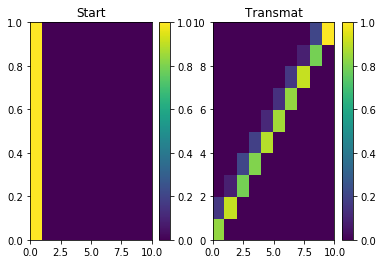

In [17]:
isolated = {}
wordHMMs = {}
for digit in prondict.keys():
    isolated[digit] = ['sil'] + prondict[digit] + ['sil']
    wordHMMs[digit] = concatHMMs(phoneHMMs_one, isolated[digit])
_ = plt.subplot(122).set_title("Transmat")
_ = plt.pcolormesh(wordHMMs['o']['transmat'].T)
_ = plt.colorbar()
_ = plt.subplot(121).set_title("Start")
_ = plt.pcolormesh(wordHMMs['o']['startprob'].T)
_ = plt.colorbar()

### 5.1 Gaussian emission probabilities

obsloglik  ✓


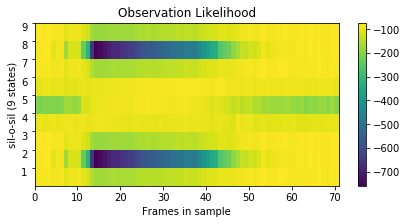

In [18]:
obsloglik = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs['o']['means'], wordHMMs['o']['covars'])  
if np.allclose(obsloglik, example["obsloglik"]):
    print("obsloglik ", u'\u2713')
_ = plt.rcParams['figure.figsize'] = [15, 3]
_ = plt.subplot(121).set_title("Observation Likelihood")
_ = plt.pcolormesh(obsloglik.T)
_ = plt.colorbar()
_ = plt.yticks(range(1,10), verticalalignment='top')
_ = plt.xlabel('Frames in sample')
_ = plt.ylabel('sil-o-sil (9 states)')
# _ = plt.subplot(122).set_title("Example")
# _ = plt.pcolormesh(example["obsloglik"].T)

Here we plot the probablities of each state given an instance in the utterance of the sound.  
And we also know that each phoneme's model is made of 3 states. So the word model on O is made of 3 phoneme models of O(ow) and 2 sil's in the start and end. So the first and last frames of the sample are mostly silent and the middle frames correspond to the word 'O'

From the color bar blue is negative 700 i.e the pobability that the model is that state given the corresponding frame is lower and higher when its yellow.

Thus as expected the start and end of the sample is more yellow in the states 1,2,3 and 7,8,9 and yellow in the middle in states of 4,5,6 which is the word 'O'

### 5.2 Forward Algorithm

In [19]:
def forward(log_emlik, log_startprob, log_transmat):
    """Forward (alpha) probabilities in log domain.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: log transition probability from state i to j

    Output:
        forward_prob: NxM array of forward log probabilities for each of the M states in the model
    """
    alpha = np.zeros(log_emlik.shape)
    alpha[0][:] = log_startprob.T + log_emlik[0]

    for n in range(1,len(alpha)):
        for i in range(alpha.shape[1]):
            alpha[n, i] = logsumexp(alpha[n - 1] + log_transmat[:,i]) + log_emlik[n,i]
    return alpha

alpha  ✓


C:\Users\zth\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\Users\zth\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


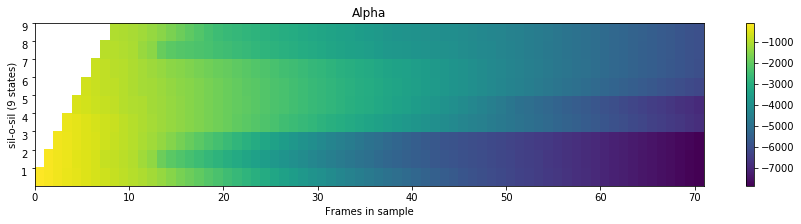

In [20]:
obsloglik = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs['o']['means'], wordHMMs['o']['covars'])  
log_startprob = np.log(wordHMMs['o']['startprob'][:-1])
log_transmat = np.log(wordHMMs['o']['transmat'][:-1,:-1])
alpha = forward(obsloglik, log_startprob, log_transmat) 
if np.allclose(alpha, example["logalpha"]):
    print("alpha ", u'\u2713')
_ = plt.rcParams['figure.figsize'] = [15, 3]
_ = plt.subplot(111).set_title("Alpha")
_ = plt.pcolormesh(alpha.T)
_ = plt.colorbar()
_ = plt.yticks(range(1,10), verticalalignment='top')
_ = plt.xlabel('Frames in sample')
_ = plt.ylabel('sil-o-sil (9 states)')
# _ = plt.subplot(122).set_title("Example")
# _ = plt.pcolormesh(example["logalpha"].T)

Forward Pass: The probabilty of observing a given sequence till that given time being in a particular state.
In other words 
##### probability of being in a state given a sequence

As given 1 sample, the model can obviously can not reach state 2 or ...9 hence their probabilty is 0 whose log is -inf and therefore not displayed on colormap with the warning divide by zero.

So from the observation likelihood calculated in the previous section, we observed that the utterance of O lies in the frames 10-50 after which 2nd silence would start. This alpha pass shows that same with higher values in 4-6 states in 10-50 frames. Also as the frames move to end the probabilities of states tend to increase as we move from state 1 to 9.

Note that the comparision of the probabilites between the frames has to be seen w.r.t to the particular frame and not in the whole colormesh.

#### the likelihood P(X|θ) of the whole sequence X = {x0, . . . , xN−1}, given the model parameters θ 
As discussed before, alpha is the probabilty of observing a given sequence till that given time being in a particular state. 
Hence the total probabilty of obeserving such a sequence with the given model is the sum of probabilties to observe the given sequence over all the possible states. 

In [21]:
hmm_loglik = logsumexp(alpha[-1]) #last coloum in alpha.T which is given all observations 
if np.allclose(hmm_loglik, example["loglik"]):
    print("loglik ", u'\u2713')
    print(hmm_loglik)

loglik  ✓
-5970.427602563561


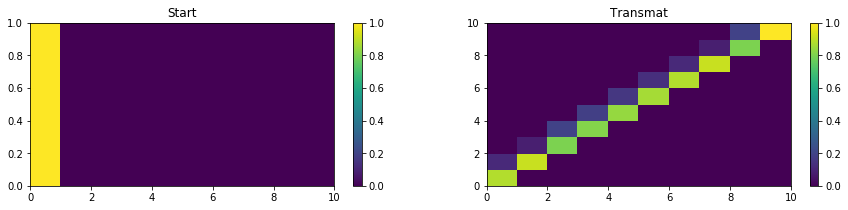

In [22]:
isolated = {}
wordHMMs_all = {}
for digit in prondict.keys():
    isolated[digit] = ['sil'] + prondict[digit] + ['sil']
    wordHMMs_all[digit] = concatHMMs(phoneHMMs_all, isolated[digit])
_ = plt.subplot(122).set_title("Transmat")
_ = plt.pcolormesh(wordHMMs_all['o']['transmat'].T)
_ = plt.colorbar()
_ = plt.subplot(121).set_title("Start")
_ = plt.pcolormesh(wordHMMs_all['o']['startprob'].T)
_ = plt.colorbar()

In [27]:
%%time
warnings.filterwarnings('ignore')
performance = np.zeros((44,11))
#for words in wordHMMs: print(words, end = "\t")
#print()
no_utterance = 0
for utterance in data:
    no_word = 0 
    for word in wordHMMs_all:
        obsloglik = log_multivariate_normal_density_diag(utterance['lmfcc'], wordHMMs_all[word]['means'], wordHMMs_all[word]['covars'])  
        log_startprob = np.log(wordHMMs_all[word]['startprob'][:-1])
        log_transmat = np.log(wordHMMs_all[word]['transmat'][:-1,:-1])
        alpha = forward(obsloglik, log_startprob, log_transmat) 
        hmm_loglik = logsumexp(alpha[-1]) 
        performance[no_utterance, no_word] = hmm_loglik
        #print(int(hmm_loglik), end = "\t")
        #print(no_utterance,no_word ,end = '\t')
        no_word += 1
    #print()
    no_utterance += 1
#uncomment prints to display as tables with integer values

Wall time: 16.8 s


In [24]:
import sys
print(sys.version)

3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]


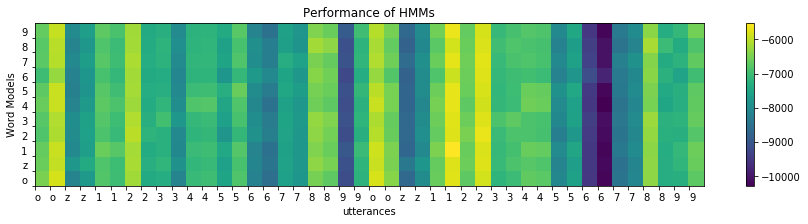

In [28]:
all_words = []
for x in wordHMMs_all: all_words.append(x)
all_utterance = []   
for x in data: all_utterance.append(x['digit'])
_ = plt.rcParams['figure.figsize'] = [15, 3]
_ = plt.subplot(111).set_title("Performance of HMMs")
_ = plt.pcolormesh(performance.T)
_ = plt.colorbar()
_ = plt.ylabel('Word Models')
_ = plt.xlabel('utterances')
_ = plt.yticks(range(len(all_words)), all_words, verticalalignment = 'bottom')
_ = plt.xticks(range(len(all_utterance)), all_utterance, horizontalalignment = 'left')

Accuracy : 97.72727272727273


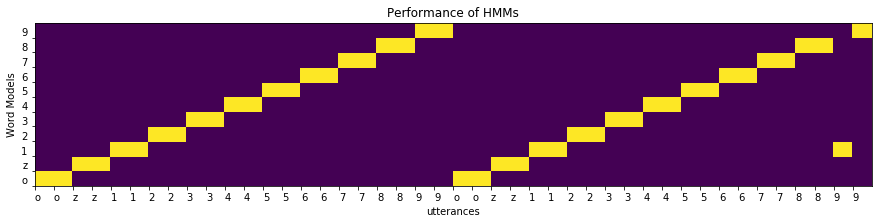

In [29]:
performance_max = np.copy(performance.T)
predictions_alpha = (performance_max == performance_max.max(axis = 0,keepdims = 1))
_ = plt.rcParams['figure.figsize'] = [15, 3]
_ = plt.subplot(111).set_title("Performance of HMMs")
_ = plt.pcolormesh(predictions_alpha)
_ = plt.ylabel('Word Models')
_ = plt.xlabel('utterances')
_ = plt.yticks(range(len(all_words)), all_words, verticalalignment = 'bottom')
_ = plt.xticks(range(len(all_utterance)), all_utterance, horizontalalignment = 'left')
match = 0
for i in range(len(all_words)):
    for j in range(len(all_utterance)):
        if(predictions_alpha[i,j] == True and all_words[i] == all_utterance[j]):
            match += 1
print("Accuracy :", 100*float(match)/predictions_alpha.shape[1])

###### Complexity:
CPU times: user 20.9 s, sys: 28 ms, total: 21 s   
Wall time: 20.9 s
###### Accuracy
One Speaker - 77.27% 
All Speakers - 97.72%

### 5.3 Viterbi Approximation
##### finding the most likely sequence of hidden states

In [30]:
def viterbi(log_emlik, log_startprob, log_transmat, forceFinalState=True):
    """Viterbi path.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: transition log probability from state i to j
        forceFinalState: if True, start backtracking from the final state in
                  the model, instead of the best state at the last time step

    Output:
        viterbi_loglik: log likelihood of the best path
        viterbi_path: best path
    """
    
    N = log_emlik.shape[0]
    M = log_emlik.shape[1]
    
    viterbi_path = np.empty((N), dtype=np.int)
    viterbi_loglik = 0
    V = np.zeros((N,M))
    B = np.zeros((N,M))
    
    for j in range(M):
        V[0, j] = log_startprob[j] + log_emlik[0,j]
        
    for n in range(1,N):
        for j in range(M):
            V[n, j] = np.max(V[n-1,:] + log_transmat[:,j]) + log_emlik[n,j]
            B[n, j] = np.argmax(V[n-1,:] + log_transmat[:,j])
    
    viterbi_path[-1] = np.argmax(V[-1, :])
    viterbi_loglik = V[N-1, viterbi_path[-1]]
    
    for n in range(0,N-1):
        viterbi_path[n] += np.max(V[n-1,:])
    
    for n in reversed(range(N-1)):
        for j in range(M):
            viterbi_path[n] = B[n+1, viterbi_path[n+1]]
            
    return (viterbi_loglik, viterbi_path)

In [31]:
obsloglik = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs['o']['means'], wordHMMs['o']['covars'])  
log_startprob = np.log(wordHMMs['o']['startprob'][:-1])
log_transmat = np.log(wordHMMs['o']['transmat'][:-1,:-1])
alpha = forward(obsloglik, log_startprob, log_transmat) 
vloglik, vpath = viterbi(obsloglik, log_startprob, log_transmat)
if np.allclose(vloglik, example['vloglik']):
    print("vloglik ", u'\u2713')
if np.allclose(vpath, example['vpath']):
    print("vpath ", u'\u2713')

vloglik  ✓
vpath  ✓


[1 2 2 2 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 8 9 9 9 9 9 9 9 9 9 9]


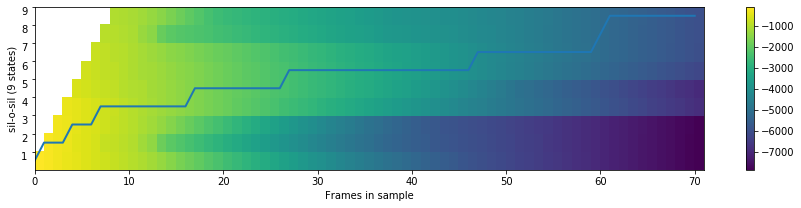

In [32]:
_ = plt.figure(figsize=(15,3))
_ = plt.pcolormesh(np.ma.masked_array(alpha.T))
_ = plt.plot(vpath+0.5, linewidth = 2)
_ = plt.colorbar()
_ = plt.yticks(range(1,10), verticalalignment='top')
_ = plt.xlabel('Frames in sample')
_ = plt.ylabel('sil-o-sil (9 states)')
print(vpath+1)

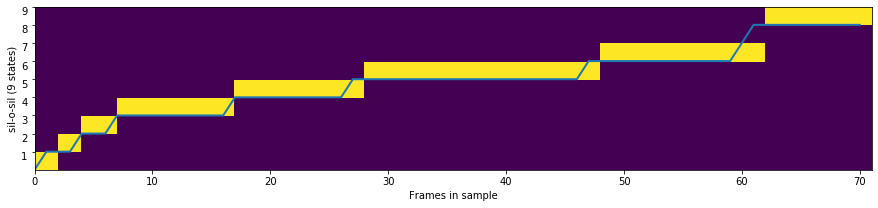

In [33]:
alpha_max = np.copy(alpha.T)
alpha_max = (alpha_max == alpha_max.max(axis = 0,keepdims = 1))
_ = plt.figure(figsize=(15,3))
_ = plt.pcolormesh(np.ma.masked_array(alpha_max))
_ = plt.plot(vpath, linewidth = 2)
_ = plt.yticks(range(1,10), verticalalignment='top')
_ = plt.xlabel('Frames in sample')
_ = plt.ylabel('sil-o-sil (9 states)')

In [34]:
%%time
warnings.filterwarnings('ignore')
performance = np.zeros((44,11))
#for words in wordHMMs: print(words, end = "\t")
#print()
no_utterance = 0
for utterance in data:
    no_word = 0 
    for word in wordHMMs_all:
        obsloglik = log_multivariate_normal_density_diag(utterance['lmfcc'], wordHMMs_all[word]['means'], wordHMMs_all[word]['covars'])  
        log_startprob = np.log(wordHMMs_all[word]['startprob'][:-1])
        log_transmat = np.log(wordHMMs_all[word]['transmat'][:-1,:-1])
        vloglik, vpath = viterbi(obsloglik, log_startprob, log_transmat)
        performance[no_utterance, no_word] = vloglik
        #print(int(hmm_loglik), end = "\t")
        #print(no_utterance,no_word ,end = '\t')
        no_word += 1
    #print()
    no_utterance += 1
#uncomment prints to display as tables with integer values

OverflowError: Python int too large to convert to C long

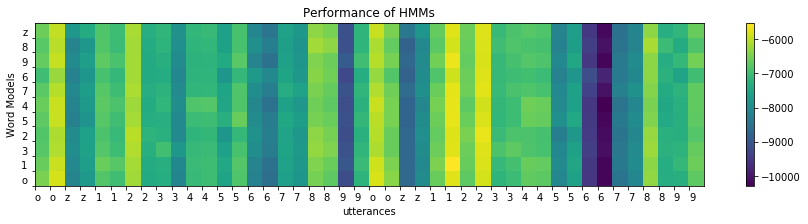

In [25]:
all_words = []
for x in wordHMMs_all: all_words.append(x)
all_utterance = []   
for x in data: all_utterance.append(x['digit'])
_ = plt.rcParams['figure.figsize'] = [15, 3]
_ = plt.subplot(111).set_title("Performance of HMMs")
_ = plt.pcolormesh(performance.T)
_ = plt.colorbar()
_ = plt.ylabel('Word Models')
_ = plt.xlabel('utterances')
_ = plt.yticks(range(len(all_words)), all_words, verticalalignment = 'bottom')
_ = plt.xticks(range(len(all_utterance)), all_utterance, horizontalalignment = 'left')

Accuracy : 100.0


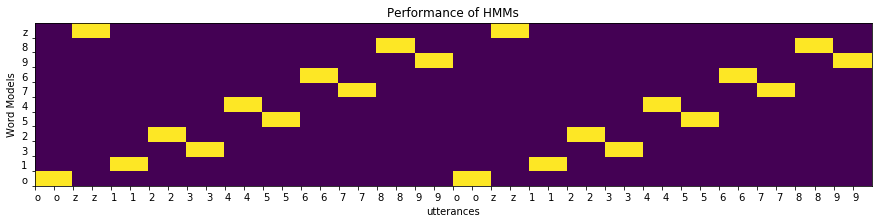

In [26]:
performance_max = np.copy(performance.T)
predictions_viterbi = (performance_max == performance_max.max(axis = 0,keepdims = 1))
_ = plt.rcParams['figure.figsize'] = [15, 3]
_ = plt.subplot(111).set_title("Performance of HMMs")
_ = plt.pcolormesh(predictions_viterbi)
_ = plt.ylabel('Word Models')
_ = plt.xlabel('utterances')
_ = plt.yticks(range(len(all_words)), all_words, verticalalignment = 'bottom')
_ = plt.xticks(range(len(all_utterance)), all_utterance, horizontalalignment = 'left')
match = 0
for i in range(len(all_words)):
    for j in range(len(all_utterance)):
        if(predictions_viterbi[i,j] == True and all_words[i] == all_utterance[j]):
            match += 1
print("Accuracy :", 100*float(match)/predictions_viterbi.shape[1])

###### Complexity:
CPU times: user 7.51 s, sys: 4 ms, total: 7.52 s
Wall time: 7.51 s
###### Accuracy
One Speaker - 77.27% 
All Speakers - 100%

Viterbi faster than alpha pass/forward
Accuracies are same for one speaker   
For all speakers viterbi performs perfect   
but alpha have some wrong predictions

### 5.4 Backward Algorithm
###### Probability of the next observation given a state

In [37]:
def backward(log_emlik, log_startprob, log_transmat):
    """Backward (beta) probabilities in log domain.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: transition log probability from state i to j

    Output:
        backward_prob: NxM array of backward log probabilities for each of the M states in the model
    """

    N, M = log_emlik.shape
    beta = np.empty((N,M))
    beta[-1,:] = 0
    for n in reversed(range(N-1)):
        for i in range(M):
            beta[n,i] = logsumexp(log_transmat[i,:] + log_emlik[n+1,:] + beta[n+1,:])
    return beta

logbeta  ✓


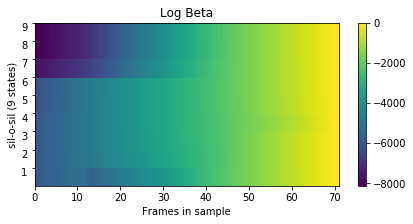

In [65]:
obsloglik = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs['o']['means'], wordHMMs['o']['covars'])  
log_startprob = np.log(wordHMMs['o']['startprob'][:-1])
log_transmat = np.log(wordHMMs['o']['transmat'][:-1,:-1])
beta = backward(obsloglik, log_startprob, log_transmat)
if np.allclose(beta, example['logbeta']):
    print("logbeta ", u'\u2713')
    _ = plt.rcParams['figure.figsize'] = [15, 3]
_ = plt.subplot(121).set_title("Log Beta")
_ = plt.pcolormesh(beta.T)
_ = plt.colorbar()
_ = plt.yticks(range(1,10), verticalalignment='top')
_ = plt.xlabel('Frames in sample')
_ = plt.ylabel('sil-o-sil (9 states)')

### 6 HMM Retraining (emission probability distributions)

### 6.1 State posterior probabilities / Gamma

###### Given the entire observation sequence and current estimate of the HMM, what is the probability that at time (t) the hidden state is (Xt=i)

In [66]:
def statePosteriors(log_alpha, log_beta):
    """State posterior (gamma) probabilities in log domain.

    Args:
        log_alpha: NxM array of log forward (alpha) probabilities
        log_beta: NxM array of log backward (beta) probabilities
    where N is the number of frames, and M the number of states

    Output:
        log_gamma: NxM array of gamma probabilities for each of the M states in the model
    """
    N = len(log_alpha)
    log_gamma = log_alpha + log_beta - logsumexp(log_alpha[N - 1])
    return log_gamma

In [62]:
def statePosteriors2(log_alpha, log_beta):
    """State posterior (gamma) probabilities in log domain.
    Args:
        log_alpha: NxM array of log forward (alpha) probabilities
        log_beta: NxM array of log backward (beta) probabilities
    where N is the number of frames, and M the number of states
    Output:
        log_gamma: NxM array of gamma probabilities for each of the M states in the model
    """
    N, M = log_alpha.shape
    log_gamma = np.zeros(np.shape(log_alpha))
    
    for n in range(N):
        log_gamma[n] = log_alpha[n] + log_beta[n] - logsumexp(log_alpha[N-1])    
    
    return log_gamma

In [67]:
obsloglik = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs['o']['means'], wordHMMs['o']['covars'])  
log_startprob = np.log(wordHMMs['o']['startprob'][:-1])
log_transmat = np.log(wordHMMs['o']['transmat'][:-1,:-1])
alpha = forward(obsloglik, log_startprob, log_transmat) 
gamma = statePosteriors(alpha, beta)

In [68]:
gamma.shape

(71, 9)

In [40]:
print(np.sum(np.exp(gamma), axis = 1))
print("gamma" , u'\u2713')
print("Sum of gamma at each time stamp is 1")

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
gamma ✓
Sum of gamma at each time stamp is 1


In [69]:
np.sum(np.exp(gamma), axis = 1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [70]:
np.around(np.sum(np.exp(gamma), axis = 0))

array([ 1.,  2.,  4., 10., 10., 21., 13.,  1.,  9.])

In [71]:
np.sum(np.around(np.sum(np.exp(gamma), axis = 1)))

71.0

In [72]:
gamma.shape

(71, 9)

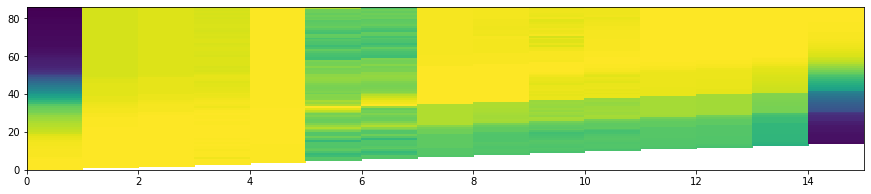

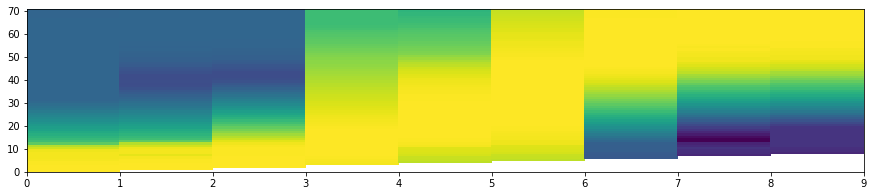

In [60]:
plt.pcolormesh(gamma)
plt.show()
plt.pcolormesh(example['loggamma'])
plt.show()

In [61]:
log_startprob = np.log(wordHMMs['o']['startprob'][:-1])
log_transmat = np.log(wordHMMs['o']['transmat'][:-1,:-1])
alpha = forward(hmm_loglik, log_startprob, log_transmat) 
gamma2 = statePosteriors(alpha, beta)
plt.pcolormesh(gamma2)
plt.show()

IndexError: invalid index to scalar variable.

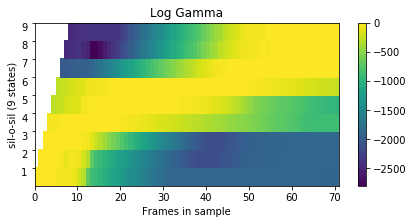

In [41]:
_ = plt.rcParams['figure.figsize'] = [15, 3]
_ = plt.subplot(121).set_title("Log Gamma")
_ = plt.pcolormesh(gamma.T)
_ = plt.colorbar()
_ = plt.yticks(range(1,10), verticalalignment='top')
_ = plt.xlabel('Frames in sample')
_ = plt.ylabel('sil-o-sil (9 states)')

In [42]:
def updateMeanAndVar(X, log_gamma, varianceFloor=5.0):
    """ Update Gaussian parameters with diagonal covariance

    Args:
         X: NxD array of feature vectors
         log_gamma: NxM state posterior probabilities in log domain
         varianceFloor: minimum allowed variance scalar
    were N is the lenght of the observation sequence, D is the
    dimensionality of the feature vectors and M is the number of
    states in the model

    Outputs:
         means: MxD mean vectors for each state
         covars: MxD covariance (variance) vectors for each state
    """
    gamma = np.exp(log_gamma)
    means = np.zeros((log_gamma.shape[1], X.shape[1]))
    covars = np.zeros(means.shape)

    for i in range(means.shape[0]):
        gamma_sum = np.sum(gamma[:,i])
        means[i] = np.sum(gamma[:,i].reshape(-1, 1) * X, axis = 0) / gamma_sum
        covars[i] = np.sum(gamma[:,i].reshape(-1, 1) * (X - means[i])**2, axis = 0) / gamma_sum
        covars[i, covars[i] < varianceFloor] = varianceFloor
    return (means, covars)

In [43]:
prev_loglik = None
threshold = 1
iterations = 20
model = {}
model = wordHMMs_all.copy() 
train_log = []
for i in tqdm(range(iterations)):
    obsloglik = log_multivariate_normal_density_diag(data[10]['lmfcc'], model['4']['means'], model['4']['covars'])  

    log_startprob = np.log(model['4']['startprob'][:-1])
    log_transmat = np.log(model['4']['transmat'][:-1,:-1])

    #Expectation
    alpha = forward(obsloglik, log_startprob, log_transmat) 
    beta = backward(obsloglik, log_startprob, log_transmat)
    gamma = statePosteriors(alpha, beta)
    hmm_loglik = logsumexp(alpha[-1]) 
    if(prev_loglik is None):
        prev_loglik = hmm_loglik
    elif(hmm_loglik - prev_loglik > threshold):
         prev_loglik = hmm_loglik
    else:
        continue
        #print("last iteration update, prev", hmm_loglik , prev_loglik)
        
    #Maximization
    model['4']['means'], model['4']['covars'] = updateMeanAndVar(data[10]['lmfcc'], gamma)
    train_log.append(hmm_loglik)
    
print(train_log)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 15.01it/s]

[-6826.654332902908, -6154.595775649375, -6022.524852217406, -5998.157284976011, -5994.049059721674]


Model -4 itself

25%|██▌       | 5/20 [00:00<00:01,  9.08it/s]  
last iteration update, prev -5994.049059632479 -5994.049059721665  
[-6826.654332902908, -6154.595775649375, -6022.524852217402, -5998.1572849760105, -5994.049059721665]

Model - o

20%|██        | 4/20 [00:00<00:01, 13.95it/s]
last iteration update, prev -6318.813712693775 -6318.817002586534
[-7070.173641433824, -6451.2981231871045, -6352.529477038947, -6321.501698999799, -6318.817002586534]

On model - 6

25%|██▌       | 5/20 [00:00<00:01,  7.52it/s]  
last iteration update, prev -5884.1937370000305 -5884.590499120586  
[-7193.099605598604, -6146.134276859259, -5934.147135682102, -5890.096108797846, -5884.590499120586]  

In [9]:
!ls ../../pianition/data/
#np.load()

data_split.py  data_wav2mfcc.py  debug	download_data.sh  info.npz  samples


In [13]:
example = np.load("../../pianition/data/info.npz")

In [25]:
example = np.load("../../pianition/data/samples/sample_0.npz")

In [30]:
example['arr_0']

array([0,
       array([[-51.13649706, -57.55455145, -54.91131611, ..., -80.        ,
        -80.        , -80.        ],
       [-50.54549067, -57.21450772, -54.84034495, ..., -80.        ,
        -80.        , -80.        ],
       [-51.73453702, -53.02902767, -50.7946863 , ..., -80.        ,
        -80.        , -80.        ],
       ...,
       [-48.28879541, -49.58829745, -53.50298634, ..., -80.        ,
        -80.        , -80.        ],
       [-50.80009713, -50.19312771, -52.68157524, ..., -80.        ,
        -80.        , -80.        ],
       [-48.75718429, -55.51081931, -52.22407127, ..., -80.        ,
        -80.        , -80.        ]])], dtype=object)

In [29]:
print(example['arr_0'][x] for x in range(len(example['arr_0'])))

<generator object <genexpr> at 0x7fab97b79d00>


In [44]:
example = np.load("../../pianition/data/info.npz")
example = example['info']#["composer_to_id"]
#example['composer_to_id']

In [45]:
example

array({'n_samples': 1282, 'composer_to_id': {'Nikolai Medtner': 47, 'Johann Pachelbel': 31, 'Johannes Brahms': 38, 'Johann Christian Fischer / Wolfgang Amadeus Mozart': 30, 'Alban Berg': 0, 'Muzio Clementi': 45, 'Sergei Rachmaninoff / György Cziffra': 58, 'Henry Purcell': 26, 'Jean-Philippe Rameau': 29, 'Richard Wagner / Franz Liszt': 54, 'Johann Sebastian Bach / Egon Petri': 33, 'Franz Liszt / Camille Saint-Saëns': 13, 'Wolfgang Amadeus Mozart': 60, 'Isaac Albéniz / Leopold Godowsky': 28, 'Anton Arensky': 2, 'Robert Schumann / Franz Liszt': 56, 'Giuseppe Verdi / Franz Liszt': 25, 'Joseph Haydn': 39, 'Johann Sebastian Bach / Myra Hess': 36, 'Carl Maria von Weber': 4, 'Georges Bizet / Vladimir Horowitz': 24, 'Mikhail Glinka / Mily Balakirev': 42, 'Ludwig van Beethoven': 41, 'Percy Grainger': 50, 'Pyotr Ilyich Tchaikovsky': 51, 'Johann Sebastian Bach': 32, 'Edvard Grieg': 9, 'Johann Sebastian Bach / Ferruccio Busoni': 34, 'Claude Debussy': 6, 'Leoš Janáček': 40, 'Georges Bizet / Ferrucci

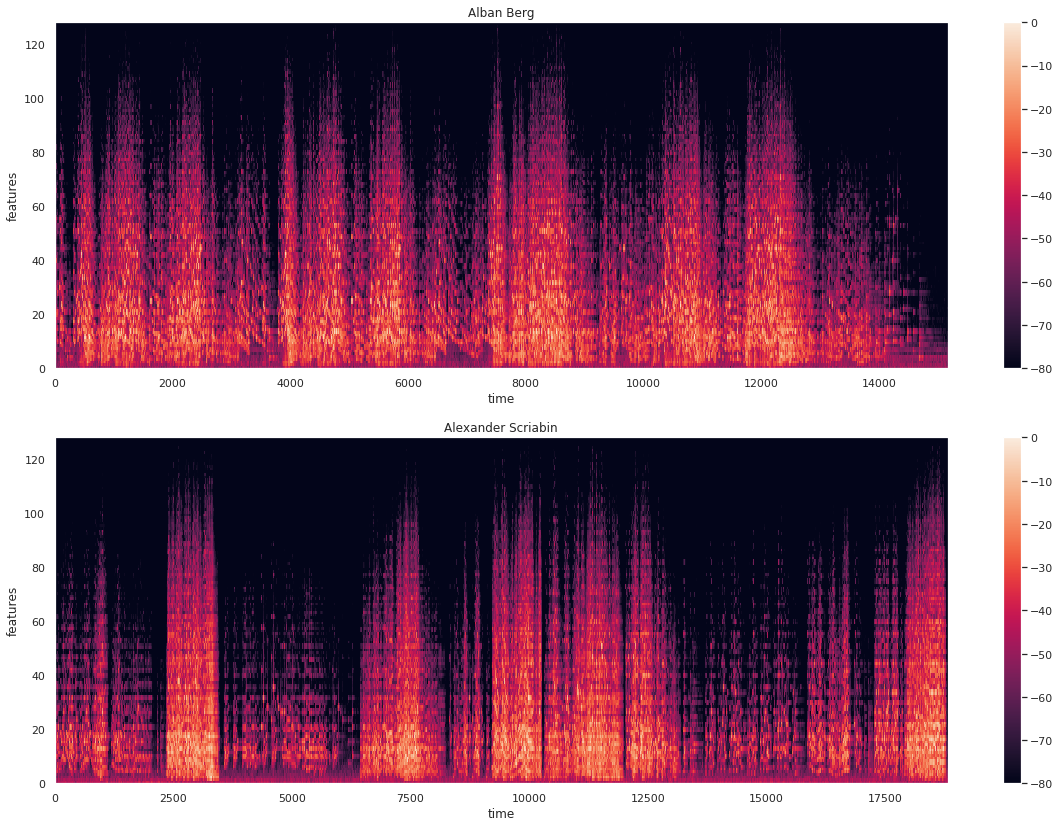

In [7]:
sns.set()
sample = np.load("/media/datta/Sri Datta/sample_0.npz")
lmfcc1 = sample["arr_0"][1]

sample = np.load("/media/datta/Sri Datta/sample_3.npz")
lmfcc2 = sample["arr_0"][1]
_ = plt.rcParams['figure.figsize'] = [20, 14]

_ = plt.subplot(211).set_title("Alban Berg")
_ = plt.pcolormesh(lmfcc1.T)
_ = plt.colorbar()
_ = plt.xlabel('time')
_ = plt.ylabel('features')
_ = plt.subplot(212).set_title("Alexander Scriabin")
_ = plt.pcolormesh(lmfcc2.T)
_ = plt.colorbar()
_ = plt.xlabel('time')
_ = plt.ylabel('features')
plt.savefig('/media/datta/Sri Datta/samp.png')
